In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import geopandas as gpd


pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100


import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc


import plotly.express as px

from paths import *
from scripts import vis_simulaCovid

import yaml


## SimulaCovid API ('http://datasource.coronacidades.org:7000/')
- br/states/rt
- br/cities/embaixadores
- br/cities/cnes
- world/owid/heatmap
- br/cities/farolcovid/main
- br/cities/rt
- br/cities/simulacovid/main
- br/cities/cases/full
- br/states/farolcovid/main


### RT

In [2]:
#load br cities
geo_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
# cols = ['geocodigo','nome_mesorregiao','geometry']
cols = ['geocodigo','nome_mesorregiao','nome_municipio']
geo_sp = geo_sp[cols]

In [3]:
#load state data
url  = 'http://datasource.coronacidades.org/'
data = 'br/states/rt'

ds = pd.read_csv(f'{url}{data}')

ds['last_updated'] = pd.to_datetime(ds['last_updated'])

sp = ds[ds['state']=='SP']
sp = sp.rename(columns={'state':'city_id'})
sp['nome_mesorregiao'] = 'SP'
sp['nome_municipio']   = 'Estado de SP'

rj = ds[ds['state']=='RJ']
rj = rj.rename(columns={'state':'city_id'})
rj['nome_mesorregiao'] = 'RJ'
rj['nome_municipio']   = 'Estado do RJ'

mg = ds[ds['state']=='MG']
mg = mg.rename(columns={'state':'city_id'})
mg['nome_mesorregiao'] = 'MG'
mg['nome_municipio']   = 'Estado de MG'

am = ds[ds['state']=='AM']
am = am.rename(columns={'state':'city_id'})
am['nome_mesorregiao'] = 'AM'
am['nome_municipio']   = 'Estado de AM'

In [4]:
#load cities data
data = 'br/cities/rt'

df = pd.read_csv(f'{url}{data}')

df['last_updated'] = pd.to_datetime(df['last_updated'])


In [20]:

dd = df.merge(geo_sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd.head()

regiao = 'Vale do Paraíba Paulista'
mask = (dd['nome_mesorregiao']==regiao)
vale = dd[mask]
vale = vale[vale['city_id'].notnull()]

mask = (dd['nome_municipio']=='São Paulo')
sp_city = dd[mask]


vale = pd.concat([vale,sp_city], 0)
vale = pd.concat([vale,sp], 0)
vale = pd.concat([vale,rj], 0)
vale = pd.concat([vale,mg], 0)
vale = pd.concat([vale,am], 0)

In [21]:
def plot_rt_final(df_final,col,N_COLS):
    
    N_ROWS = int(np.ceil(len(df_final[col].unique()) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=400)

    for i, (city, result) in enumerate(df_final.groupby(col,sort=False)):
        ax = axes.flat[i]
        vis_simulaCovid.plot_rt(result, ax, city)
    fig.tight_layout()
    fig.set_facecolor('w')
    
    return fig

In [22]:
len(vale['nome_municipio'].unique())

36

In [23]:
vale.sort_values(by='last_updated', ascending=False).head()

city_id last_updated  Rt_most_likely  Rt_low_95  Rt_high_95  \
264             AM   2020-07-02            0.88       0.83        0.92   
21399  3.54230e+06   2020-07-02            1.58       0.75        2.38   
23854   3.5482e+06   2020-07-02            2.03       1.16        2.84   
9724    3.5184e+06   2020-07-02            1.27       0.97        1.54   
972             MG   2020-07-02            1.30       1.26        1.34   

       data_last_refreshed  geocodigo          nome_mesorregiao  \
264    2020-07-03 18:10:45        NaN                        AM   
21399  2020-07-03 19:11:03  3542305.0  Vale do Paraíba Paulista   
23854  2020-07-03 19:11:03  3548203.0  Vale do Paraíba Paulista   
9724   2020-07-03 19:11:03  3518404.0  Vale do Paraíba Paulista   
972    2020-07-03 18:10:45        NaN                        MG   

                nome_municipio  
264               Estado de AM  
21399        Redenção da Serra  
23854  Santo Antônio do Pinhal  
9724             Guaratinguetá  
972               Estado de MG

In [24]:
fig = plot_rt_final(ds,'state',3)
fig.savefig("/home/m/Downloads/Evolucao da Taxa de Transmissão Efetiva - Estados.pdf.pdf", bbox_inches='tight')

In [25]:
last_date = max(vale['last_updated']).strftime('%d-%m-%Y')

fig = plot_rt_final(vale,'nome_municipio',4)

fig.savefig(f"/home/m/Downloads/Evolucao da Taxa de Transmissão Efetiva - Vale do Paraíba e Litoral Norte.pdf", bbox_inches='tight')

## Selected cities

In [26]:
## Rt for most recent date
max_date = max(vale['last_updated'])
vale_last_date = vale.drop_duplicates('nome_municipio', keep='last').sort_values(by='Rt_most_likely')
last_date = max_date.strftime('%Y-%m-%d')
fig = vis_simulaCovid.plot_rt_bars(vale_last_date, title= f'Taxa Transmissão Efetiva em {last_date}', place_type='nome_municipio')

In [27]:
fig = fig.update_xaxes(tickangle=30)
fig.write_image(f"/home/m/Downloads/Taxa Transmissão Efetiva em {last_date}.pdf", width=1080, height=720)

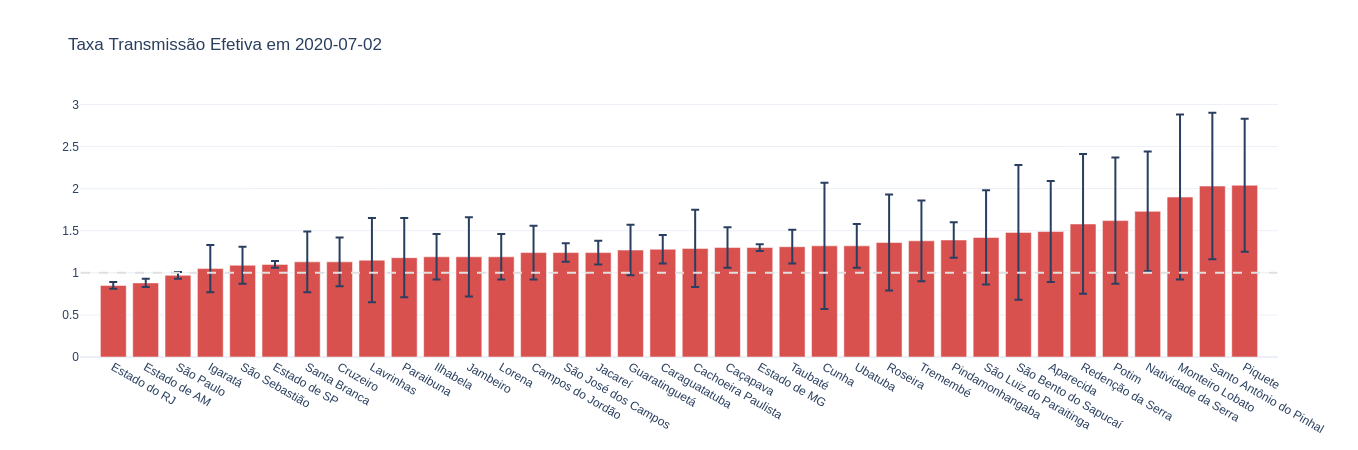

In [28]:
fig

In [29]:
vale_last_date['nome_municipio']

1698                Estado do RJ
264                 Estado de AM
25222                  São Paulo
10670                    Igaratá
25420              São Sebastião
2338                Estado de SP
22814               Santa Branca
7163                    Cruzeiro
14217                  Lavrinhas
18371                  Paraibuna
10823                   Ilhabela
13394                   Jambeiro
14647                     Lorena
5349            Campos do Jordão
24851        São José dos Campos
13123                    Jacareí
9724               Guaratinguetá
5789               Caraguatatuba
4603          Cachoeira Paulista
4523                    Caçapava
972                 Estado de MG
27196                    Taubaté
7291                       Cunha
27757                    Ubatuba
22204                    Roseira
27456                   Tremembé
19433            Pindamonhangaba
24950     São Luiz do Paraitinga
24031       São Bento do Sapucaí
1261                   Aparecida
21399     

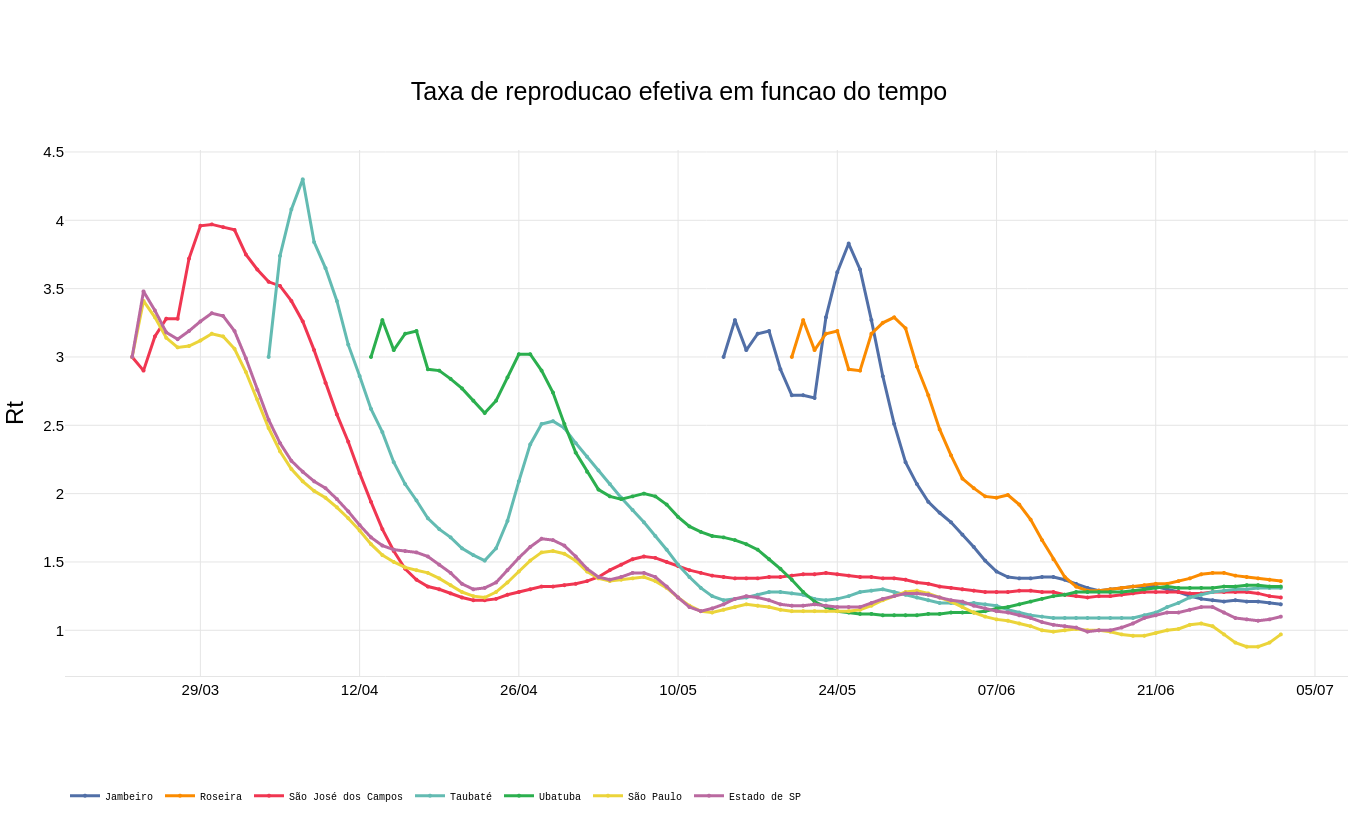

In [30]:
municipios = ['São Paulo', 'Estado de SP', 'Taubaté', 'São José dos Campos', 'Jambeiro','Roseira','Ubatuba']
vale_filtered = vale[vale['nome_municipio'].isin(municipios)]



themes = yaml.load(open('../themes/themes_simulaCovid.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['rt_selected_cities']
fig = vis_simulaCovid.plot_rt_plotly(vale_filtered, themes)

fig

## BR

In [31]:
br = pd.read_csv('../../brasil_geodata/maps/br_municipios_ibge.csv')
br = br[['geocodigo','nome_municipio','nome_uf']]

br_rt_full = df.copy()
br_rt_full = br.merge(br_rt_full, how='right', left_on = 'geocodigo', right_on = 'city_id')




br_rt = br_rt_full.sort_values(by='last_updated', ascending=False).groupby(by='city_id', as_index=False).first().sort_values(by='Rt_most_likely', ascending=True)




In [32]:
br_rt.head(3)

city_id  geocodigo nome_municipio   nome_uf last_updated  Rt_most_likely  \
574  2111300    2111300       São Luís  Maranhão   2020-07-02            0.66   
833  2304400    2304400      Fortaleza     Ceará   2020-07-02            0.76   
122  1304203    1304203           Tefé  Amazonas   2020-07-02            0.77   

     Rt_low_95  Rt_high_95  data_last_refreshed  
574       0.57        0.72  2020-07-03 19:11:03  
833       0.69        0.79  2020-07-03 19:11:03  
122       0.64        0.86  2020-07-03 19:11:03

In [33]:
municipios = br_rt.head(3)['nome_municipio'].tolist() + ['São Paulo', 'Estado de SP', 'Taubaté', 'São José dos Campos', 'Assis']

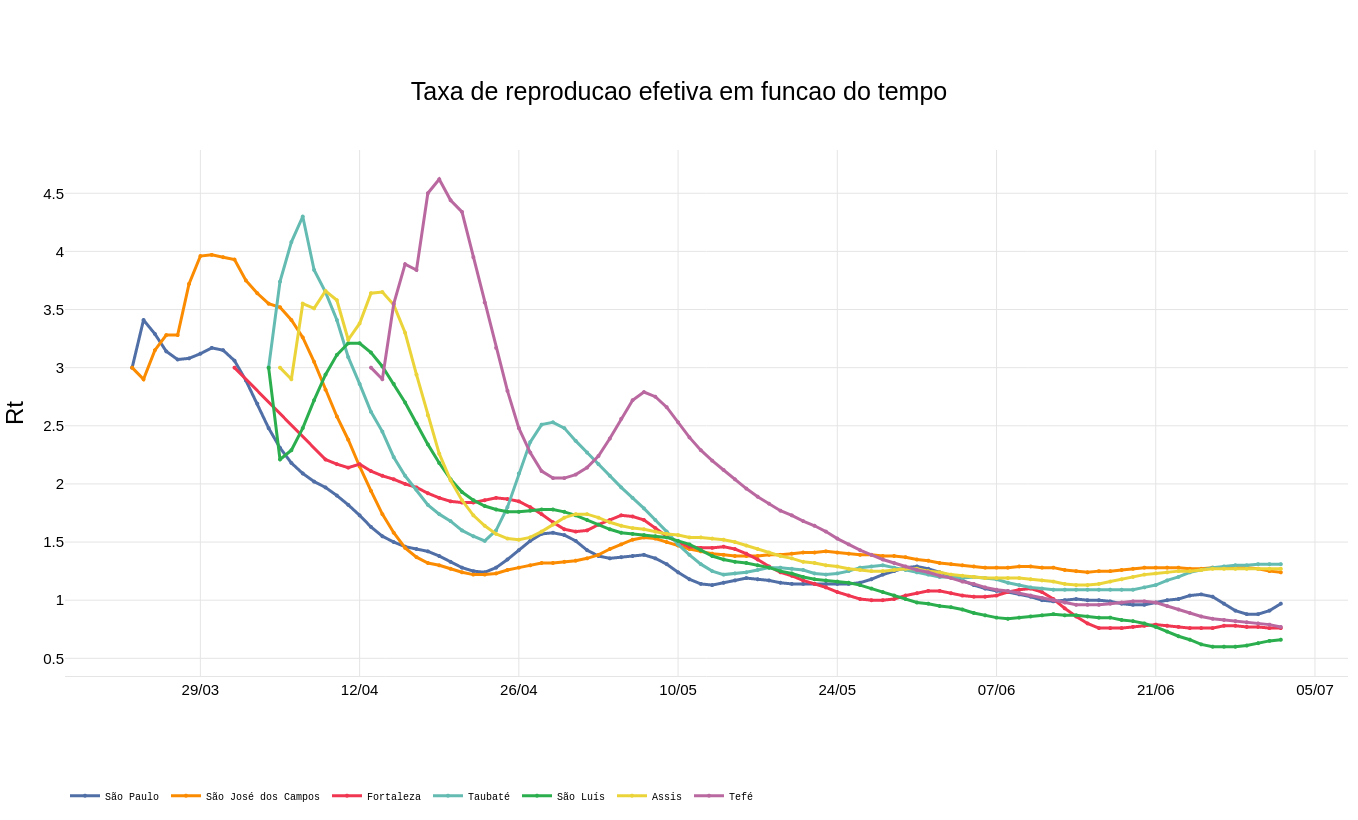

In [34]:
br_rt_filtered = br_rt_full[br_rt_full['nome_municipio'].isin(municipios)].sort_values(by='last_updated')



themes = yaml.load(open('../themes/themes_simulaCovid.yaml', 'r'), Loader=yaml.FullLoader)
themes = themes['rt_selected_cities']
fig = vis_simulaCovid.plot_rt_plotly(br_rt_filtered, themes)

fig

## RT MAP

In [ ]:
#load br cities
sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
cols = ['geocodigo','nome_mesorregiao','geometry']
sp = sp[cols]

In [ ]:
#load data
url  = 'http://datasource.coronacidades.org:7000/'
data = 'br/cities/farolcovid/main'

df = pd.read_csv(f'{url}{data}')

dd = df.merge(sp, how='right', left_on = 'city_id', right_on = 'geocodigo')
dd = gpd.GeoDataFrame(dd)


regiao = 'Vale do Paraíba Paulista'
mask = dd['nome_mesorregiao']==regiao
vale = dd[mask]

vale = gpd.GeoDataFrame(vale)

In [116]:
def plot_map(dd,var):
    fig = plt.figure(figsize=(25,25))
    ax  = fig.add_subplot(1,1,1)
    ax.set_title(f'{var}', fontsize=23)


    missings={
        "color": "white",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }


    # dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[0.75,1]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,100,500,1000,10000]},missing_kwds=missings )
#     dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[1,5,10,50,100,500,1000,3000]},missing_kwds=missings )
    dd.plot(column=var,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff",  scheme='user_defined', classification_kwds={'bins':[10,30,50,70]},missing_kwds=missings )

#     dd.plot(column=var ,ax=ax, legend=True,cmap='Oranges', edgecolor = "#ffffff" ,missing_kwds=missings, scheme='quantiles',k=30)

    ax.axis('off')


    plt.rc('legend',fontsize='large')

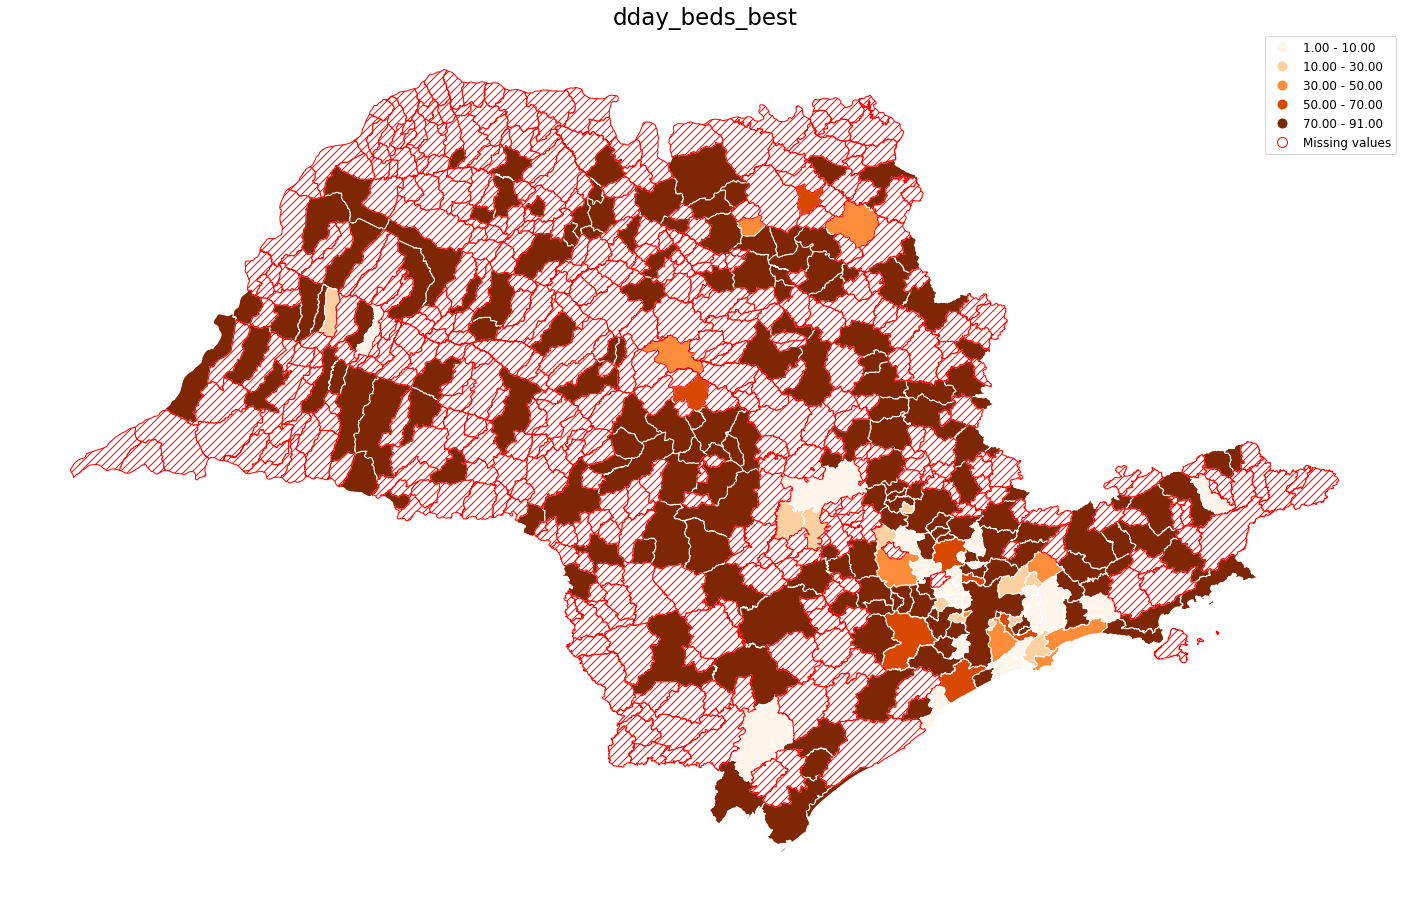

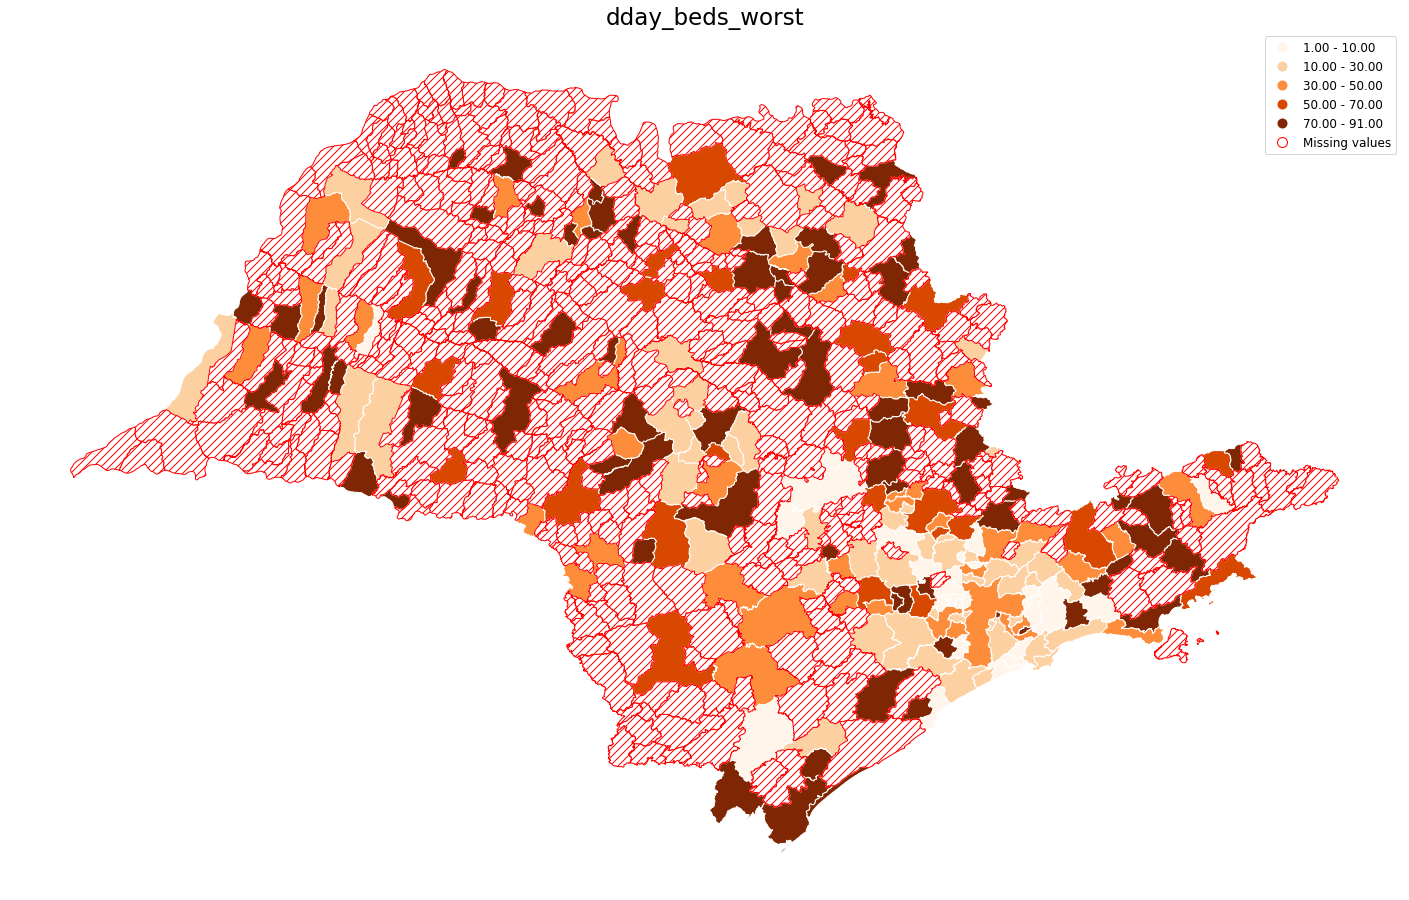

In [117]:
var = 'dday_beds_best'

plot_map(dd,var)


var = 'dday_beds_worst'

plot_map(dd,var)



# var = 'rt_10days_ago_avg'

# plot_map(dd,var)

# var = 'rt_ratio_week_avg'

# plot_map(dd,var)